In [1]:
import os
import re

In [2]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import sys
sys.path.append('../../TINY/')
import UTILS 
import torch
import os
from tqdm.notebook import tqdm

## Collect the data

In [3]:
# paths of the experiments
dirs = ['results/TINY/', 'results/GradMax/']
sub_dirs = [dir_ + p  + '/' for dir_ in dirs for p in os.listdir(dir_) if p[0] != '.']
paths = [dir_ + p  + '/' for dir_ in sub_dirs for p in os.listdir(dir_) if p[0] != '.']
nbr_tot_expe = len(paths)
paths

['results/TINY/1quart_tbadd_0.25/1/',
 'results/TINY/1quart_tbadd_1/1/',
 'results/TINY/1soixantequatre_tbadd_0.25/1/',
 'results/TINY/1soixantequatre_tbadd_1/1/',
 'results/GradMax/1quart_tbadd_0.25/1/',
 'results/GradMax/1quart_tbadd_1/1/',
 'results/GradMax/1soixantequatre_tbadd_0.25/1/',
 'results/GradMax/1soixantequatre_tbadd_1/1/']

In [4]:
expe_TINY,expe_GradMax = [], []
for i, p in enumerate(paths) :
    if 'TINY' in p :
        expe_TINY.append(i)
    elif 'GradMax' in p :
        expe_GradMax.append(i)

expes = [expe_TINY] + [expe_GradMax]

In [5]:
dico_Acc = {str(i) : {j : {} for j in expe} for i, expe in zip(['TINY', 'GradMax'], expes)}
nbr_parameters = []
tbadds = []
inits = []
for IndiceExpe, GrowingMethod in zip(expes, [str(j) for j in ['TINY', 'GradMax']]) :
    for i in IndiceExpe :
        path = paths[i]
        dico_Acc[GrowingMethod][i] = {}
        tbadds.append('0.25' if 'tbadd_0.25' in path else '1')
        inits.append('1/64' if 'soixante' in path else '1/4')
        if 'df_tracker.csv' in os.listdir(path) :
            df_t = pd.read_csv(path + 'df_tracker.csv')
            df_p = pd.read_csv(path + 'df_performance.csv')
            Acc = df_p['A_te'][df_t['len_L_tr']]
            Acc_tr = df_p['A_tr'][df_t['len_L_tr']]
            nbr_p = df_t['nbr_parameters_apres']
            dico_Acc[GrowingMethod][i] = {'nbr_parameters' : nbr_p, 'acc_test' : Acc, 'acc_train' : Acc_tr,
                                 'init' : inits[-1], 'tbadd' : tbadds[-1]}
        else :
            del dico_Acc[GrowingMethod][i]


## Plot the figure 5

In [6]:
dico_color = {'TINY' : 'green', 'GradMax' : 'blue'}
dico_tbadd_axs = {'0.25' : 0, '1' : 1}
dico_init_axs = {'1/4' : 0, '1/64' : 1}
dico_legend = {'TINY' : 'TINY', 'GradMax' : 'GradMax'}

In [7]:
kernel = torch.tensor([torch.sin(i) for i in torch.linspace(0, torch.pi, 5)])
kernel /= kernel.sum()

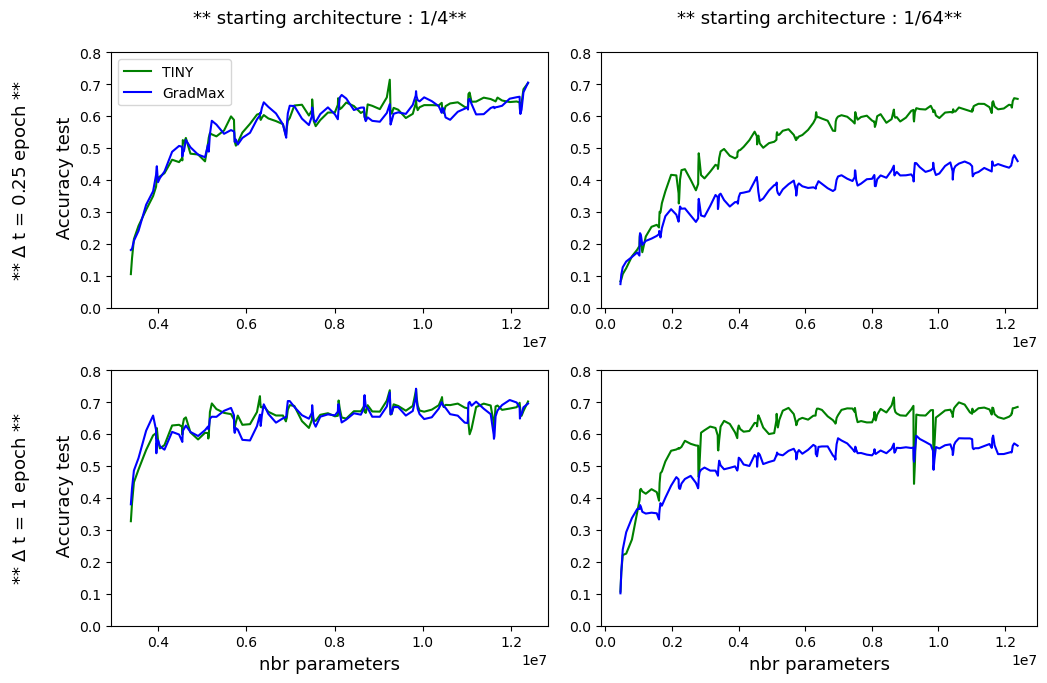

In [8]:
fig, axs = fig, axs = plt.subplots(2, 2, figsize = (10, 7))
ft = 13
for m in ['TINY', 'GradMax'] :
    for expe in dico_Acc[m].keys():
        p, tbadd, ini = dico_Acc[m][expe]['nbr_parameters'], dico_Acc[m][expe]['tbadd'], dico_Acc[m][expe]['init']
        a = dico_Acc[m][expe]['acc_test']
        
        a_smooth = torch.nn.functional.conv1d(torch.from_numpy(a.values.astype(np.float32))[None, None, :], kernel[None, None, :])[0, 0]
        p_smooth = torch.nn.functional.conv1d(torch.from_numpy(p.values.astype(np.float32))[None, None, :], kernel[None, None, :])[0, 0]
        
        indx_axs_1 = dico_init_axs[ini]
        indx_axs_0 = dico_tbadd_axs[tbadd]
        axs[indx_axs_0, indx_axs_1].plot(p_smooth, a_smooth, '-', color = dico_color[m], label = dico_legend[m])
        
    for (v_1, i_1) in dico_init_axs.items() :
        axs[0, i_1].set_title('** starting architecture : ' + str(v_1) + '**\n', fontsize = ft)


fig.tight_layout(pad=1.5)
#axs[0, 0].set_title('1/4')
#axs[0, 1].set_title('1/64')

axs[1, 0].set_ylabel(r'** $\Delta$ t = 1 epoch **' +'\n \n Accuracy test', fontsize = ft)
axs[0, 0].set_ylabel(r'** $\Delta$ t = 0.25 epoch **' + ' \n \n Accuracy test', fontsize = ft)
axs[1, 0].set_xlabel('nbr parameters', fontsize = ft)
axs[1, 1].set_xlabel('nbr parameters', fontsize = ft)    
    
handles, labels = axs[0, 1].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs[0, 0].legend(by_label.values(), by_label.keys())
vmaxy = 0.8
vminy = 0.
axs[0, 0].set_ylim((vminy,vmaxy))
axs[0, 1].set_ylim((vminy,vmaxy))
axs[1, 0].set_ylim((vminy,vmaxy))
axs[1, 1].set_ylim((vminy,vmaxy))

plt.show()